In [41]:
import pandas as pd
import numpy as np
import holidays
import warnings
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.dates as mdates
import eeweather
import pytz
import datetime
warnings.filterwarnings('ignore')

# load data

In [42]:
df = pd.read_csv('data\Mountain Parks Historical Hourly Load-2020-2023.csv')
df

,Year,Month,Day,Period,gross load
0,2020,2,7,1,43.96799
1,2020,2,7,2,43.19956
2,2020,2,7,3,42.94186
3,2020,2,7,4,43.17884
4,2020,2,7,5,43.03152
...,...,...,...,...,...
26299,2023,2,6,20,0.00000
26300,2023,2,6,21,0.00000
26301,2023,2,6,22,0.00000
26302,2023,2,6,23,0.00000


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        26304 non-null  int64  
 1   Month       26304 non-null  int64  
 2   Day         26304 non-null  int64  
 3   Period      26304 non-null  int64  
 4   gross load  26304 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 1.0 MB


In [44]:
df.rename(columns={'Year':'year', 'Month':'month', 'Day':'day', 'Period':'time', 'gross load':'gross_load'}, inplace=True)
df.tail(25)

,year,month,day,time,gross_load
26279,2023,2,5,24,45.51633
26280,2023,2,6,1,0.00000
26281,2023,2,6,2,0.00000
26282,2023,2,6,3,0.00000
26283,2023,2,6,4,0.00000
26284,2023,2,6,5,0.00000
26285,2023,2,6,6,0.00000
26286,2023,2,6,7,0.00000
26287,2023,2,6,8,0.00000
26288,2023,2,6,9,0.00000


In [45]:
def time_convert(period):
    hour = (period - 1) % 24  # Convert period to 0-23 hour range
    return f'{hour:02d}:00:00'
# Create datetime column
df['hour_begins'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df['time'].apply(time_convert))

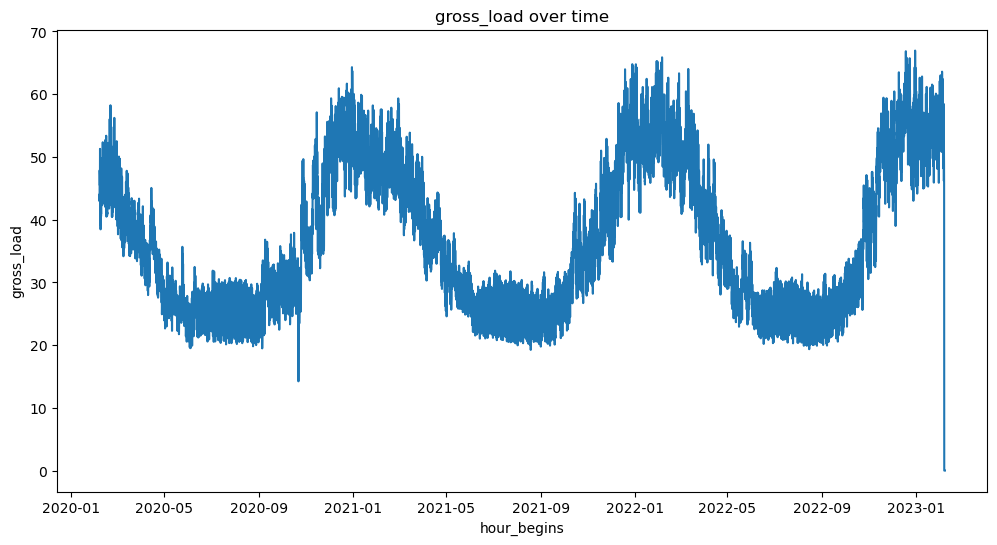

In [46]:
import matplotlib.pyplot as plt

# basic plots for actual_gross_load with x being hour_begins
plt.figure(figsize=(12, 6))
plt.plot(df['hour_begins'], df['gross_load'])
plt.title('gross_load over time')
plt.xlabel('hour_begins')
plt.ylabel('gross_load')
plt.show()

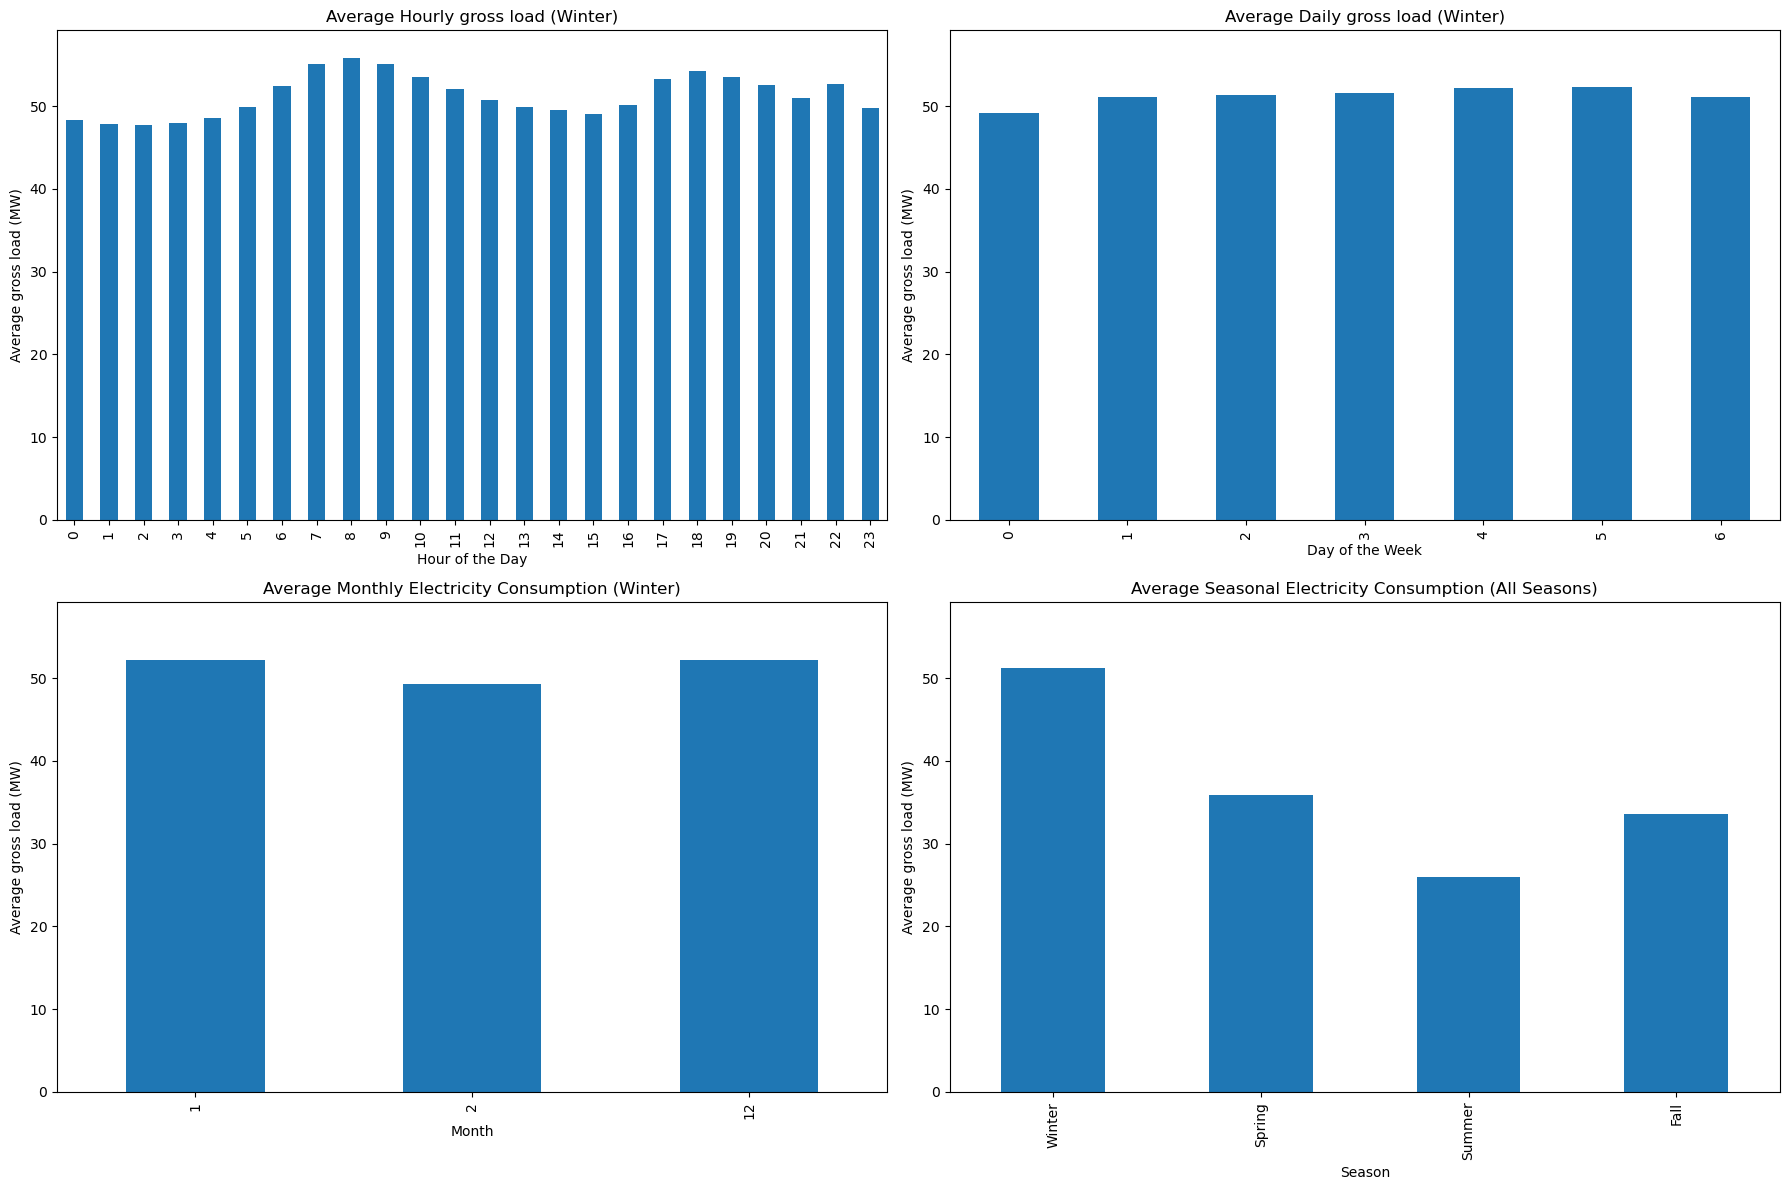

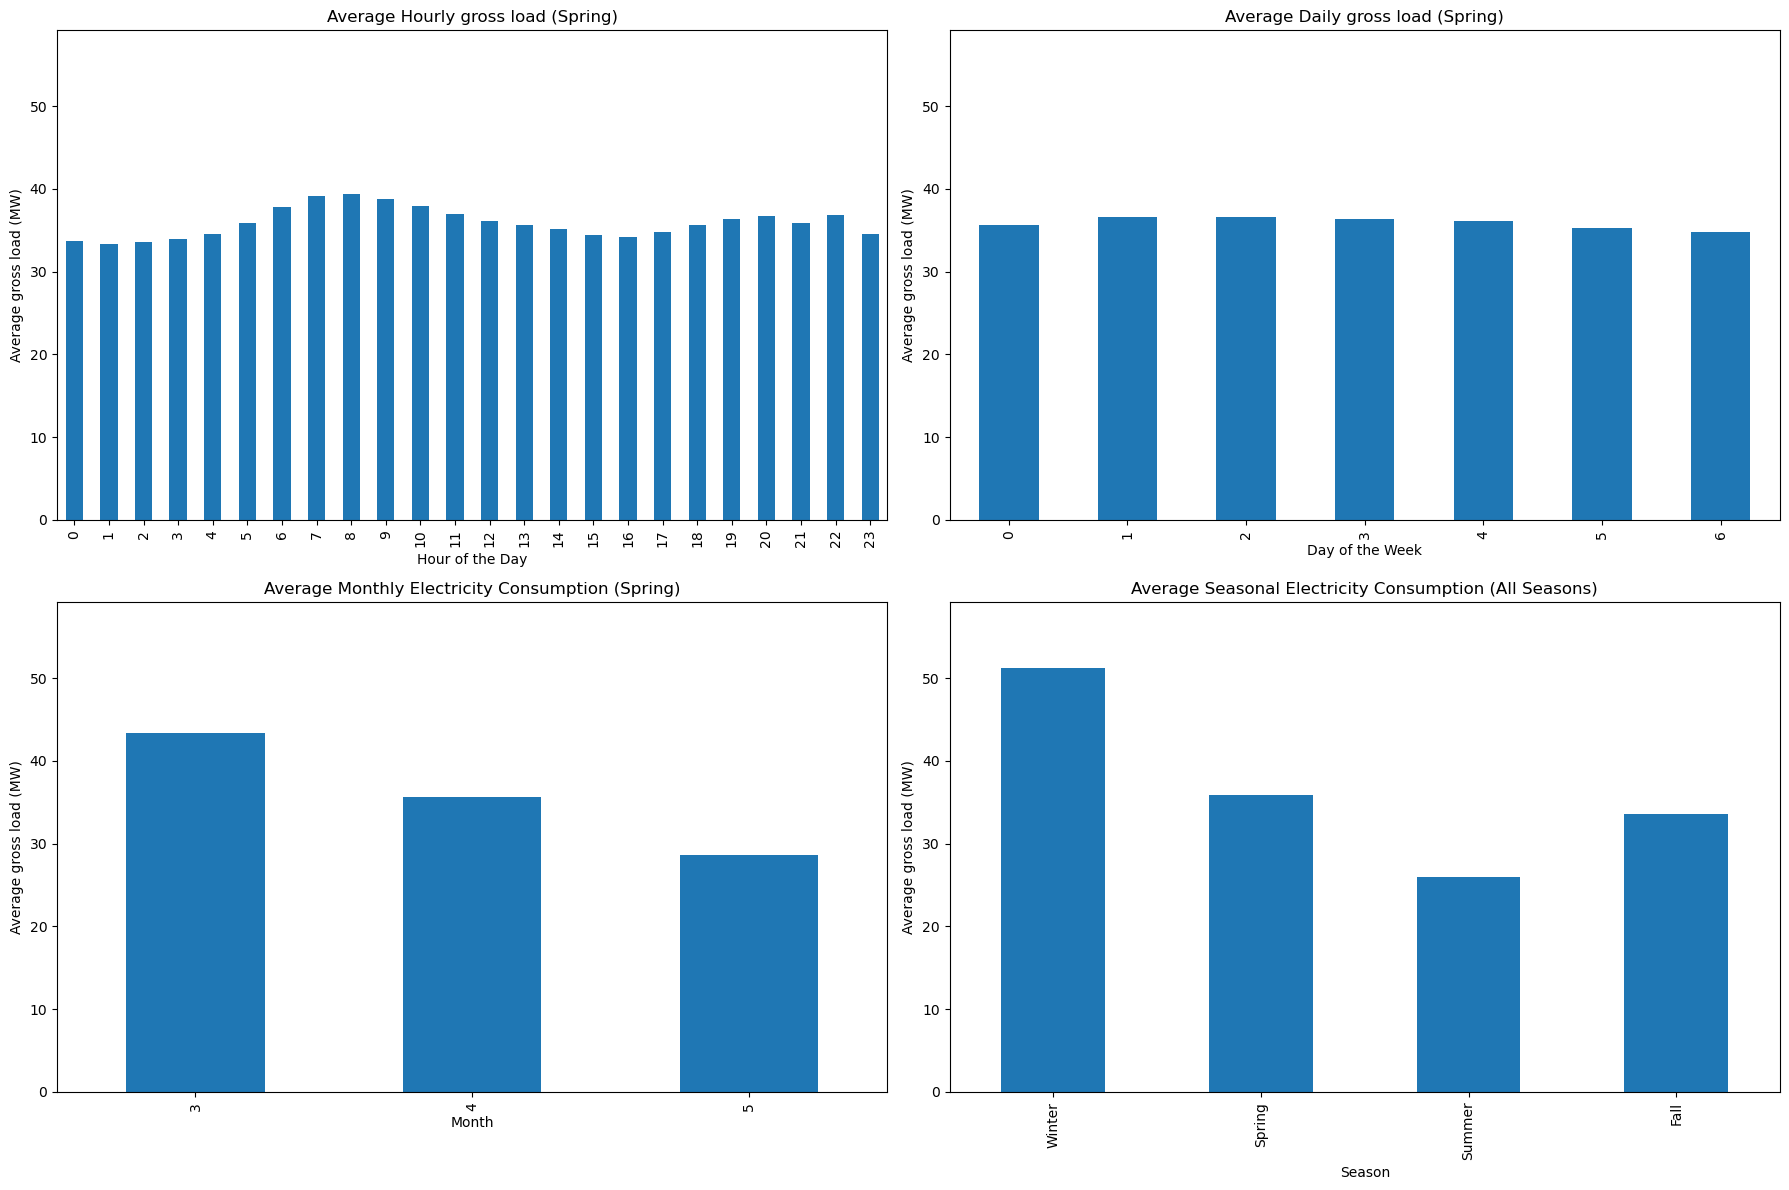

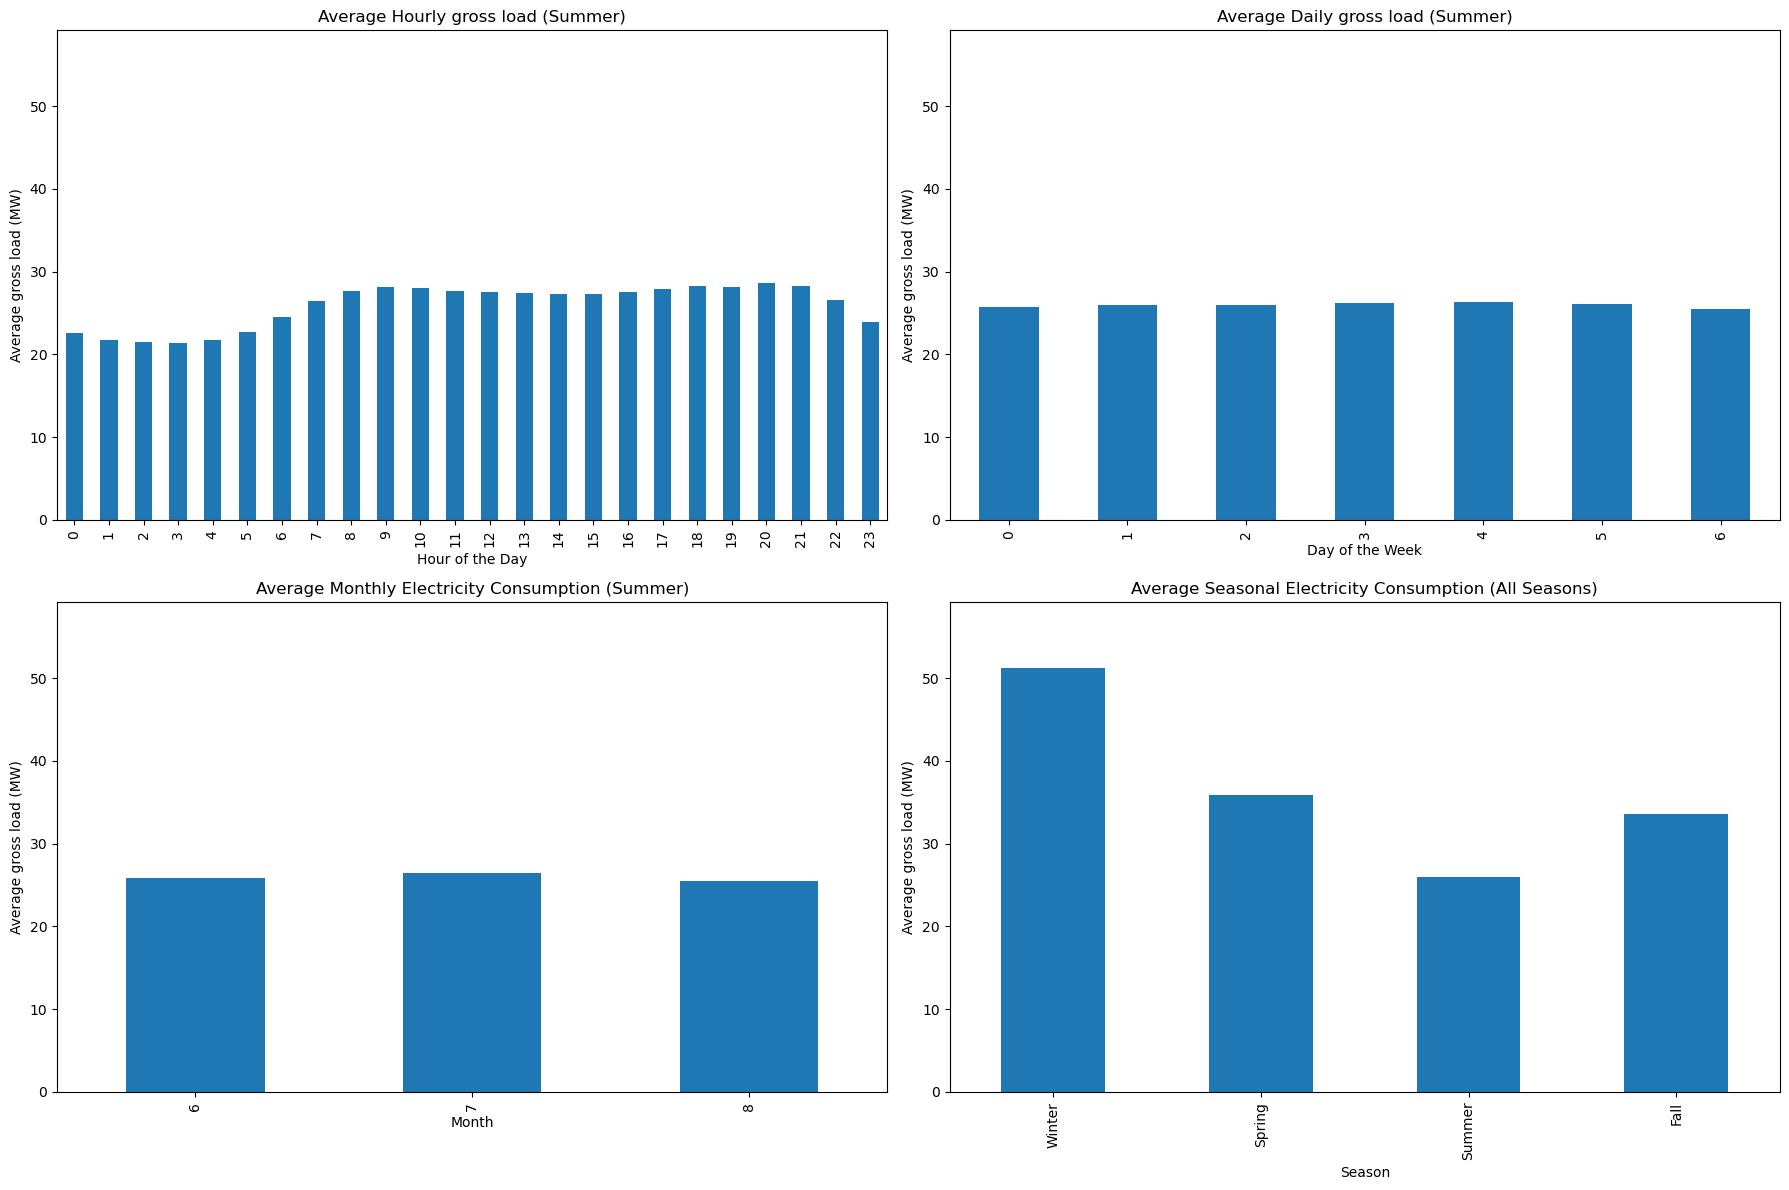

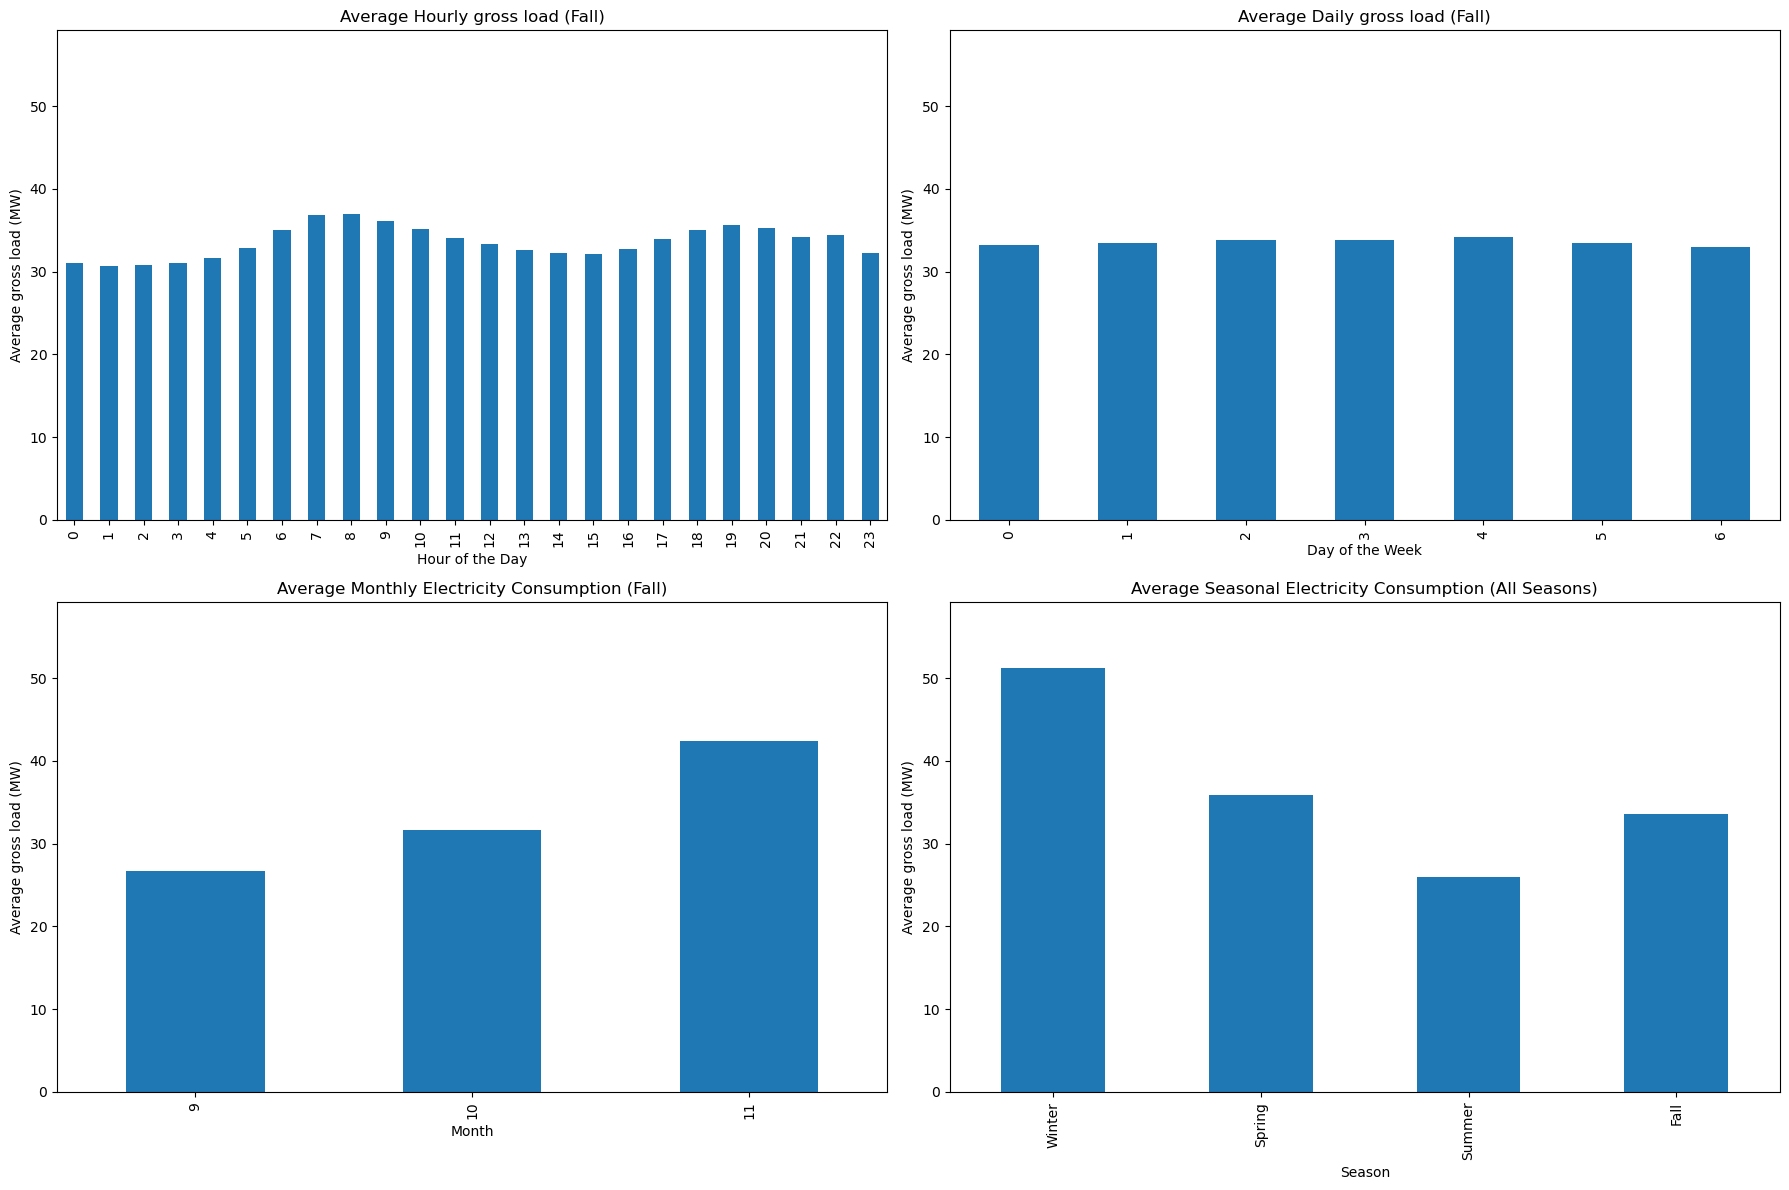

In [47]:
def plot_data(df):
    df = df.sort_values(by='hour_begins')

    # Ensure necessary time features are added
    df['hour'] = df['hour_begins'].dt.hour
    df['day_of_week'] = df['hour_begins'].dt.dayofweek
    df['month'] = df['hour_begins'].dt.month

    # Define seasons
    df['season'] = df['hour_begins'].dt.month % 12 // 3 + 1
    season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df['season'] = df['season'].map(season_mapping)

    # Calculate seasonal consumption for all seasons
    season_consumption = df.groupby('season')['gross_load'].mean().reindex(season_mapping.values())

    # Function to plot data for a given season
    def plot_season_data(season_df, season_name, season_consumption, axs, y_limit):
        # Plot by hour of the day
        hourly_consumption = season_df.groupby('hour')['gross_load'].mean()
        hourly_consumption.plot(kind='bar', ax=axs[0, 0])
        axs[0, 0].set_xlabel('Hour of the Day')
        axs[0, 0].set_ylabel('Average gross load (MW)')
        axs[0, 0].set_title(f'Average Hourly gross load ({season_name})')
        axs[0, 0].set_ylim(0, y_limit)

        # Plot by day of the week
        daily_consumption = season_df.groupby('day_of_week')['gross_load'].mean()
        daily_consumption.plot(kind='bar', ax=axs[0, 1])
        axs[0, 1].set_xlabel('Day of the Week')
        axs[0, 1].set_ylabel('Average gross load (MW)')
        axs[0, 1].set_title(f'Average Daily gross load ({season_name})')
        axs[0, 1].set_ylim(0, y_limit)

        # Plot by month within the season
        monthly_consumption = season_df.groupby('month')['gross_load'].mean()
        monthly_consumption.plot(kind='bar', ax=axs[1, 0])
        axs[1, 0].set_xlabel('Month')
        axs[1, 0].set_ylabel('Average gross load (MW)')
        axs[1, 0].set_title(f'Average Monthly Electricity Consumption ({season_name})')
        axs[1, 0].set_ylim(0, y_limit)

        # Plot seasonal consumption for all seasons
        season_consumption.plot(kind='bar', ax=axs[1, 1])
        axs[1, 1].set_xlabel('Season')
        axs[1, 1].set_ylabel('Average gross load (MW)')
        axs[1, 1].set_title('Average Seasonal Electricity Consumption (All Seasons)')
        axs[1, 1].set_ylim(0, y_limit)

    # find out the y limit as the max average value of the gross load
    y_limit = df['gross_load'].mean() + 2 * df['gross_load'].std()


    # Plot for each season
    for season, season_name in season_mapping.items():
        season_df = df[df['season'] == season_name]
        if not season_df.empty:
            fig, axs = plt.subplots(2, 2, figsize=(18, 12))
            plot_season_data(season_df, season_name, season_consumption, axs, y_limit)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No data available for {season_name}")

plot_data(df)

In [48]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the DataFrame
df['season'] = df['month'].apply(get_season)

Winter - Lower bound: 38.31, Upper bound: 63.02
Spring - Lower bound: 23.53, Upper bound: 53.98
Summer - Lower bound: 20.28, Upper bound: 30.62
Fall - Lower bound: 20.98, Upper bound: 54.95


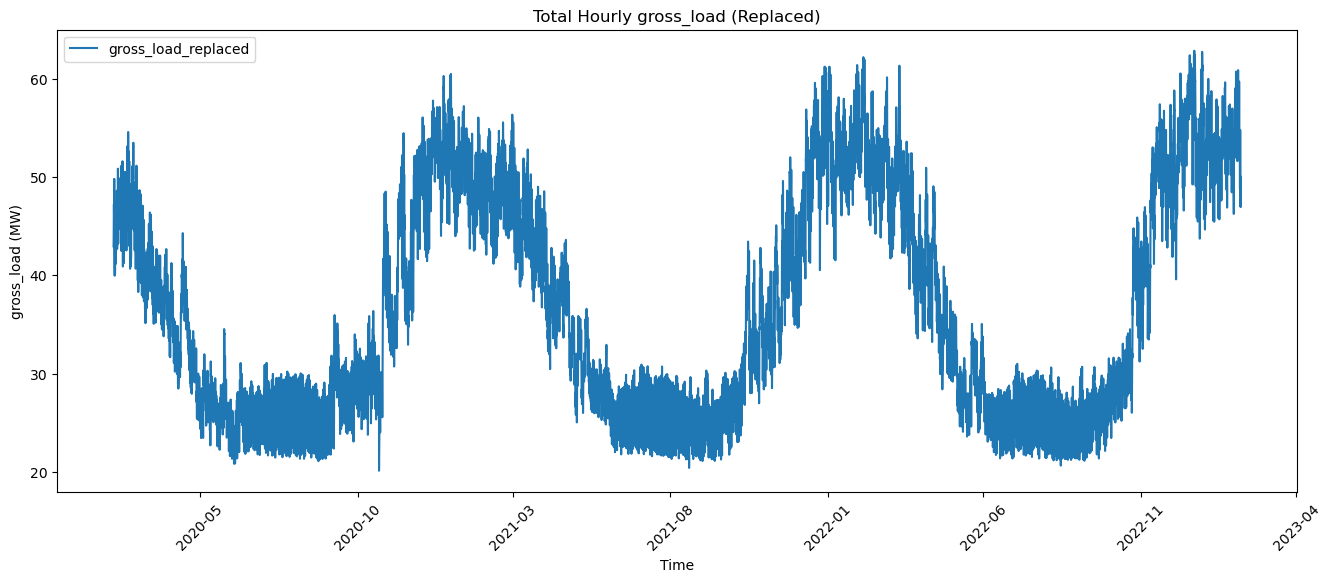

In [49]:
# Function to replace outliers within each season
def replace_outliers_with_avg_seasonal(df):
    df['gross_load_replaced'] = df['gross_load']
    for season in df['season'].unique():
        season_data = df[df['season'] == season]['gross_load']
        lower_bound = season_data.quantile(0.01)
        upper_bound = season_data.quantile(0.99)
        print(f'{season} - Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}')
        
        outliers = (df['gross_load'] < lower_bound) | (df['gross_load'] > upper_bound) | (df['gross_load'] == 0) | (df['gross_load'] == np.nan) 
        
            # Remove continuous zeros or NaNs at the end
        while pd.isna(df.iloc[-1]['gross_load_replaced']) or df.iloc[-1]['gross_load_replaced'] == 0:
            df = df.iloc[:-1]

        for idx in df[outliers].index:
            if idx == 0 or idx == len(df) - 1:
                # directly drop the first and last value
                df.at[idx, 'gross_load_replaced'] = np.nan
                continue
            # Handle edge cases where previous or next value might be NaN or zero
            prev_idx = idx - 1
            next_idx = idx + 1
            while prev_idx >= 0 and (pd.isna(df.iloc[prev_idx]['gross_load_replaced']) or df.iloc[prev_idx]['gross_load_replaced'] == 0):
                prev_idx -= 1
            while next_idx < len(df) and (pd.isna(df.iloc[next_idx]['gross_load_replaced']) or df.iloc[next_idx]['gross_load_replaced'] == 0):
                next_idx += 1
            
            if prev_idx >= 0 and next_idx < len(df):
                prev_val = df.iloc[prev_idx]['gross_load_replaced']
                next_val = df.iloc[next_idx]['gross_load_replaced']
                df.at[idx, 'gross_load_replaced'] = (prev_val + next_val) / 2
            elif prev_idx >= 0:
                df.at[idx, 'gross_load_replaced'] = df.iloc[prev_idx]['gross_load_replaced']
            elif next_idx < len(df):
                df.at[idx, 'gross_load_replaced'] = df.iloc[next_idx]['gross_load_replaced']

    return df
# Replace outliers in the 'gross_load' column using seasonal method
df = replace_outliers_with_avg_seasonal(df)

# Plot the replaced 'gross_load_replaced'
plt.figure(figsize=(16, 6))
plt.plot(df['hour_begins'], df['gross_load_replaced'], label='gross_load_replaced')
plt.xlabel('Time')
plt.ylabel('gross_load (MW)')
plt.title('Total Hourly gross_load (Replaced)')
plt.legend()

# Set date format on x-axis every 5 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26279 entries, 0 to 26278
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year                 26279 non-null  int64         
 1   month                26279 non-null  int64         
 2   day                  26279 non-null  int64         
 3   time                 26279 non-null  int64         
 4   gross_load           26279 non-null  float64       
 5   hour_begins          26279 non-null  datetime64[ns]
 6   season               26279 non-null  object        
 7   gross_load_replaced  26278 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1.6+ MB


# eeweather data

In [51]:
df['hour_begins'] = pd.to_datetime(df['hour_begins'])

mt = pytz.timezone('US/Mountain')
utc = pytz.utc

# Set the timezone for the 'hour_begins' column to Mountain Time
df['hour_begins'] = df['hour_begins'].dt.tz_localize(mt, ambiguous='NaT', nonexistent='shift_forward')

# Convert the 'hour_begins' column to UTC
df['hour_begins_utc'] = df['hour_begins'].dt.tz_convert(utc)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26279 entries, 0 to 26278
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                      
---  ------               --------------  -----                      
 0   year                 26279 non-null  int64                      
 1   month                26279 non-null  int64                      
 2   day                  26279 non-null  int64                      
 3   time                 26279 non-null  int64                      
 4   gross_load           26279 non-null  float64                    
 5   hour_begins          26276 non-null  datetime64[ns, US/Mountain]
 6   season               26279 non-null  object                     
 7   gross_load_replaced  26278 non-null  float64                    
 8   hour_begins_utc      26276 non-null  datetime64[ns, UTC]        
dtypes: datetime64[ns, US/Mountain](1), datetime64[ns, UTC](1), float64(2), int64(4), object(1)
memory usage: 1.8+ MB


In [53]:
df[df['hour_begins'].isnull()]

,year,month,day,time,gross_load,hour_begins,season,gross_load_replaced,hour_begins_utc
6433,2020,11,1,2,37.39365,NaT,Fall,37.843425,NaT
15337,2021,11,7,2,29.83625,NaT,Fall,29.911435,NaT
24073,2022,11,6,2,38.81556,NaT,Fall,38.947499,NaT


In [54]:
def eeweather_temperature(lat: float,
                          lon: float,
                          start_tzinfo_utc: datetime,
                          end_tzinfo_utc: datetime) -> pd.DataFrame:
    ranked_stations = eeweather.rank_stations(lat, lon)
    station, warnings = eeweather.select_station(ranked_stations)
    print(station.name)
    tempC = station.load_isd_hourly_temp_data(start_tzinfo_utc, end_tzinfo_utc)
    tempF = (tempC[0] * 1.8 + 32).to_frame(name='temp_f')
    print(tempF.index.is_unique, tempF.shape)
    tempF = tempF.loc[~tempF.index.duplicated(keep='first')]
    print(tempF.index.is_unique, tempF.shape)
    return tempF

df_temp = eeweather_temperature(
    lat=40.09,
    lon=-105.95,
    start_tzinfo_utc=min(df.hour_begins_utc),
    end_tzinfo_utc=max(df.hour_begins_utc)
)

GRANBY GRAND CO
True (26279, 1)
True (26279, 1)


In [55]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26279 entries, 2020-02-07 07:00:00+00:00 to 2023-02-06 05:00:00+00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp_f  24418 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [56]:
# merge the weather data with df
df = df.merge(df_temp, left_on='hour_begins_utc', right_index=True, how='left')
df.drop(columns=['hour_begins_utc'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26279 entries, 0 to 26278
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                      
---  ------               --------------  -----                      
 0   year                 26279 non-null  int64                      
 1   month                26279 non-null  int64                      
 2   day                  26279 non-null  int64                      
 3   time                 26279 non-null  int64                      
 4   gross_load           26279 non-null  float64                    
 5   hour_begins          26276 non-null  datetime64[ns, US/Mountain]
 6   season               26279 non-null  object                     
 7   gross_load_replaced  26278 non-null  float64                    
 8   temp_f               24415 non-null  float64                    
dtypes: datetime64[ns, US/Mountain](1), float64(3), int64(4), object(1)
memory usage: 1.8+ MB


# feature engineering

In [57]:
# feature engineering
df['month_sin'] = np.sin((df['month'] - 1) * (2. * np.pi / 12))
df['month_cos'] = np.cos((df['month'] - 1) * (2. * np.pi / 12))
df['day_sin'] = np.sin((df['day'] - 1) * (2. * np.pi / 31))
df['day_cos'] = np.cos((df['day'] - 1) * (2. * np.pi / 31))
df['hour_sin'] = np.sin(df['time'] * (2. * np.pi / 24))
df['hour_cos'] = np.cos(df['time'] * (2. * np.pi / 24))
df['dow'] = df['hour_begins'].dt.dayofweek # 0 means monday
df['dow_sin'] = np.sin(df['dow'] * (2. * np.pi / 7))
df['dow_cos'] = np.cos(df['dow'] * (2. * np.pi / 7))

df['season'] = ['winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' for x in df['month']]

# holiday feature
us_holidays = holidays.US()
df['holiday'] = df['hour_begins'].apply(lambda x: x in us_holidays)
df['holiday'] = df['holiday'].astype(int)

In [58]:
# 3 days shift
df_ = df.copy()

# Calculate the hour_begins 3 days ago
df_['hour_begins_3d'] = df_['hour_begins'] - pd.Timedelta(days=3)
# Rename columns to avoid duplication
df_3d = df_[['hour_begins', 'gross_load_replaced']].copy()
df_3d.columns = ['hour_begins_3d', 'gross_load_replaced_3d']

# Merge the 3 days ago data with the original data
df_merged = df_.merge(df_3d, left_on='hour_begins_3d', right_on='hour_begins_3d', how='left')

# Display information about the merged DataFrame
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26291 entries, 0 to 26290
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   year                    26291 non-null  int64                      
 1   month                   26291 non-null  int64                      
 2   day                     26291 non-null  int64                      
 3   time                    26291 non-null  int64                      
 4   gross_load              26291 non-null  float64                    
 5   hour_begins             26282 non-null  datetime64[ns, US/Mountain]
 6   season                  26291 non-null  object                     
 7   gross_load_replaced     26290 non-null  float64                    
 8   temp_f                  24421 non-null  float64                    
 9   month_sin               26291 non-null  float64                    
 10  month_cos 

In [59]:
# 3 days shift
df_ = df.copy()

# Calculate the hour_begins 3 days ago
df_['hour_begins_3d'] = df_['hour_begins'] - pd.Timedelta(days=3)
# Rename columns to avoid duplication
df_3d = df_[['hour_begins', 'gross_load_replaced']].copy()
df_3d.columns = ['hour_begins_3d', 'gross_load_replaced_3d']

# Merge the 3 days ago data with the original data
df_merged = df_.merge(df_3d, left_on='hour_begins_3d', right_on='hour_begins_3d', how='left')

# Display information about the merged DataFrame
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26291 entries, 0 to 26290
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   year                    26291 non-null  int64                      
 1   month                   26291 non-null  int64                      
 2   day                     26291 non-null  int64                      
 3   time                    26291 non-null  int64                      
 4   gross_load              26291 non-null  float64                    
 5   hour_begins             26282 non-null  datetime64[ns, US/Mountain]
 6   season                  26291 non-null  object                     
 7   gross_load_replaced     26290 non-null  float64                    
 8   temp_f                  24421 non-null  float64                    
 9   month_sin               26291 non-null  float64                    
 10  month_cos 

In [60]:
# df_merged drop nan
df_merged.dropna(inplace=True)
print(df_merged.columns)
# time stamp min and max
print(f'\nThe start hour_begins is: {df_merged['hour_begins'].min()}')
print(f'The end hour_begins is: {df_merged['hour_begins'].max()}\n')

print(df_merged.info())

Index(['year', 'month', 'day', 'time', 'gross_load', 'hour_begins', 'season',
       'gross_load_replaced', 'temp_f', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'hour_sin', 'hour_cos', 'dow', 'dow_sin', 'dow_cos',
       'holiday', 'hour_begins_3d', 'gross_load_replaced_3d'],
      dtype='object')

The start hour_begins is: 2020-02-10 01:00:00-07:00
The end hour_begins is: 2023-02-05 22:00:00-07:00

<class 'pandas.core.frame.DataFrame'>
Index: 24339 entries, 73 to 26290
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   year                    24339 non-null  int64                      
 1   month                   24339 non-null  int64                      
 2   day                     24339 non-null  int64                      
 3   time                    24339 non-null  int64                      
 4   gross_load              24339 non-nul

# preprocessing

In [61]:
df_merged.columns

Index(['year', 'month', 'day', 'time', 'gross_load', 'hour_begins', 'season',
       'gross_load_replaced', 'temp_f', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'hour_sin', 'hour_cos', 'dow', 'dow_sin', 'dow_cos',
       'holiday', 'hour_begins_3d', 'gross_load_replaced_3d'],
      dtype='object')

In [62]:
# reorder the columns
column = ['hour_begins','gross_load_replaced_3d', 'year', 'month', 'dow',  'season', 'holiday', 'temp_f', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos','dow_sin', 'dow_cos', 'gross_load_replaced' ]
LSTM_df = df_merged[column]

In [63]:
LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24339 entries, 73 to 26290
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   hour_begins             24339 non-null  datetime64[ns, US/Mountain]
 1   gross_load_replaced_3d  24339 non-null  float64                    
 2   year                    24339 non-null  int64                      
 3   month                   24339 non-null  int64                      
 4   dow                     24339 non-null  float64                    
 5   season                  24339 non-null  object                     
 6   holiday                 24339 non-null  int32                      
 7   temp_f                  24339 non-null  float64                    
 8   month_sin               24339 non-null  float64                    
 9   month_cos               24339 non-null  float64                    
 10  hour_sin      

In [64]:
LSTM_df = pd.get_dummies(LSTM_df, columns=['season'], drop_first=True) # at the last 3 columns
# Convert boolean columns to integers
for col in LSTM_df.columns:
    if LSTM_df[col].dtype == 'bool':
        LSTM_df[col] = LSTM_df[col].astype(int)
# place the target variable at the last column
LSTM_df = LSTM_df[[c for c in LSTM_df if c not in ['gross_load_replaced']] + ['gross_load_replaced']]
LSTM_df

,hour_begins,gross_load_replaced_3d,year,month,dow,holiday,temp_f,month_sin,month_cos,hour_sin,hour_cos,dow_sin,dow_cos,season_spring,season_summer,season_winter,gross_load_replaced
73,2020-02-10 01:00:00-07:00,42.941860,2020,2,0.0,0,14.78750,0.5,0.866025,0.500000,8.660254e-01,0.000000,1.00000,0,0,1,43.062059
74,2020-02-10 02:00:00-07:00,43.060350,2020,2,0.0,0,13.53506,0.5,0.866025,0.707107,7.071068e-01,0.000000,1.00000,0,0,1,42.931899
75,2020-02-10 03:00:00-07:00,43.045935,2020,2,0.0,0,12.89444,0.5,0.866025,0.866025,5.000000e-01,0.000000,1.00000,0,0,1,43.241065
76,2020-02-10 04:00:00-07:00,43.540413,2020,2,0.0,0,12.00506,0.5,0.866025,0.965926,2.588190e-01,0.000000,1.00000,0,0,1,44.335952
77,2020-02-10 05:00:00-07:00,44.722146,2020,2,0.0,0,10.79906,0.5,0.866025,1.000000,6.123234e-17,0.000000,1.00000,0,0,1,46.050581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26286,2023-02-05 18:00:00-07:00,54.655649,2023,2,6.0,0,30.20594,0.5,0.866025,-0.965926,2.588190e-01,-0.781831,0.62349,0,0,1,50.055118
26287,2023-02-05 19:00:00-07:00,55.388812,2023,2,6.0,0,28.21856,0.5,0.866025,-0.866025,5.000000e-01,-0.781831,0.62349,0,0,1,49.671869
26288,2023-02-05 20:00:00-07:00,55.885323,2023,2,6.0,0,29.78456,0.5,0.866025,-0.707107,7.071068e-01,-0.781831,0.62349,0,0,1,48.735795
26289,2023-02-05 21:00:00-07:00,56.054530,2023,2,6.0,0,31.66556,0.5,0.866025,-0.500000,8.660254e-01,-0.781831,0.62349,0,0,1,48.484027


In [65]:
# scaling the columns except for the 1 column
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
LSTM_df.iloc[:, 1:] = scaler.fit_transform(LSTM_df.iloc[:, 1:])
LSTM_df

,hour_begins,gross_load_replaced_3d,year,month,dow,holiday,temp_f,month_sin,month_cos,hour_sin,hour_cos,dow_sin,dow_cos,season_spring,season_summer,season_winter,gross_load_replaced
73,2020-02-10 01:00:00-07:00,0.534038,0.0,0.090909,0.0,0,0.326507,0.75,0.933013,0.750000,0.933013,0.500000,1.000000,0,0,1,0.536855
74,2020-02-10 02:00:00-07:00,0.536815,0.0,0.090909,0.0,0,0.314952,0.75,0.933013,0.853553,0.853553,0.500000,1.000000,0,0,1,0.533804
75,2020-02-10 03:00:00-07:00,0.536477,0.0,0.090909,0.0,0,0.309042,0.75,0.933013,0.933013,0.750000,0.500000,1.000000,0,0,1,0.541050
76,2020-02-10 04:00:00-07:00,0.548065,0.0,0.090909,0.0,0,0.300836,0.75,0.933013,0.982963,0.629410,0.500000,1.000000,0,0,1,0.566709
77,2020-02-10 05:00:00-07:00,0.575760,0.0,0.090909,0.0,0,0.289710,0.75,0.933013,1.000000,0.500000,0.500000,1.000000,0,0,1,0.606893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26286,2023-02-05 18:00:00-07:00,0.808558,1.0,0.090909,1.0,0,0.468756,0.75,0.933013,0.017037,0.629410,0.099031,0.801938,0,0,1,0.700742
26287,2023-02-05 19:00:00-07:00,0.825740,1.0,0.090909,1.0,0,0.450420,0.75,0.933013,0.066987,0.750000,0.099031,0.801938,0,0,1,0.691760
26288,2023-02-05 20:00:00-07:00,0.837376,1.0,0.090909,1.0,0,0.464868,0.75,0.933013,0.146447,0.853553,0.099031,0.801938,0,0,1,0.669822
26289,2023-02-05 21:00:00-07:00,0.841342,1.0,0.090909,1.0,0,0.482222,0.75,0.933013,0.250000,0.933013,0.099031,0.801938,0,0,1,0.663922


In [66]:
LSTM_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24339 entries, 73 to 26290
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   hour_begins             24339 non-null  datetime64[ns, US/Mountain]
 1   gross_load_replaced_3d  24339 non-null  float64                    
 2   year                    24339 non-null  float64                    
 3   month                   24339 non-null  float64                    
 4   dow                     24339 non-null  float64                    
 5   holiday                 24339 non-null  int32                      
 6   temp_f                  24339 non-null  float64                    
 7   month_sin               24339 non-null  float64                    
 8   month_cos               24339 non-null  float64                    
 9   hour_sin                24339 non-null  float64                    
 10  hour_cos      

# dividing the dataset

In [67]:
years_of_data = len(LSTM_df) / (365 * 24)
print(f'Total years of data: {years_of_data}')

LSTM_df = LSTM_df.sort_values(by = 'hour_begins', ascending = True)
print(f'Total number of days for training: {LSTM_df.shape[0]}')

Total years of data: 2.7784246575342464
Total number of days for training: 24339


In [68]:
values = LSTM_df.drop(columns='hour_begins').values
hour_begins = LSTM_df['hour_begins']

# out of sample data: total length multiplies 0.3
n_train_hours = int(values.shape[0] * 0.8)
# in sample data: the rest of the data
train = values[:n_train_hours, :]
train_timestamps = hour_begins[:n_train_hours]
# print(f'start date of in sample data: {train["date"].min()}')
# print(f'end date of in sample data: {train["date"].max()}')
# print(f'length of in sample data: {train.
# shape[0]}\n')

print(f'min: {train_timestamps.min()}')
print(f'max: {train_timestamps.max()}')
print(f'length of training data: {train.shape[0]}\n')

test = values[n_train_hours:, : ]
test_timestamps = hour_begins[n_train_hours:]
# print(f'start date of out of sample data: {test["date"].min()}')
# print(f'end date of out of sample data: {test["date"].max()}')
# print(f'length of out of sample data: {test.shape[0]}\n')

print(f'min: {test_timestamps.min()}')
print(f'max: {test_timestamps.max()}')
print(f'length of testing data: {test.shape[0]}')

min: 2020-02-10 01:00:00-07:00
max: 2022-07-17 07:00:00-06:00
length of training data: 19471

min: 2022-07-17 08:00:00-06:00
max: 2023-02-05 22:00:00-07:00
length of testing data: 4868


In [69]:
# dividing the data into x and y
# x: All columns except the last,  y: The last column
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(19471, 1, 15) (19471,) (4868, 1, 15) (4868,)


# training the model

In [70]:
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
# design network

# Define the model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.25))
model.add(Dense(1))
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', 'mape'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

# Fit the network
history = model.fit(train_X, train_y, epochs=300, batch_size=90, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False,callbacks=[early_stopping, reduce_lr])

# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
# calculate train validate rmse, mae, mape
train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
train_mae = mean_absolute_error(train_y, train_predictions)
train_mape = safe_mape(train_y, train_predictions)

test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
test_mae = mean_absolute_error(test_y, test_predictions)
test_mape = safe_mape(test_y, test_predictions)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")

Epoch 1/300
217/217 - 1s - 5ms/step - loss: 0.2845 - mae: 0.2845 - mape: 372.9596 - mse: 0.1322 - val_loss: 0.2873 - val_mae: 0.2873 - val_mape: 88.6005 - val_mse: 0.1340 - learning_rate: 1.0000e-04
Epoch 2/300
217/217 - 0s - 737us/step - loss: 0.1932 - mae: 0.1932 - mape: 8390.1836 - mse: 0.0629 - val_loss: 0.2327 - val_mae: 0.2327 - val_mape: 89.9839 - val_mse: 0.0804 - learning_rate: 1.0000e-04
Epoch 3/300
217/217 - 0s - 736us/step - loss: 0.1574 - mae: 0.1574 - mape: 8181.0757 - mse: 0.0406 - val_loss: 0.1876 - val_mae: 0.1876 - val_mape: 81.3271 - val_mse: 0.0507 - learning_rate: 1.0000e-04
Epoch 4/300
217/217 - 0s - 864us/step - loss: 0.1307 - mae: 0.1307 - mape: 13845.5820 - mse: 0.0276 - val_loss: 0.1487 - val_mae: 0.1487 - val_mape: 70.7025 - val_mse: 0.0320 - learning_rate: 1.0000e-04
Epoch 5/300
217/217 - 0s - 748us/step - loss: 0.1096 - mae: 0.1096 - mape: 17781.0625 - mse: 0.0193 - val_loss: 0.1213 - val_mae: 0.1213 - val_mape: 60.4270 - val_mse: 0.0218 - learning_rate: 1.

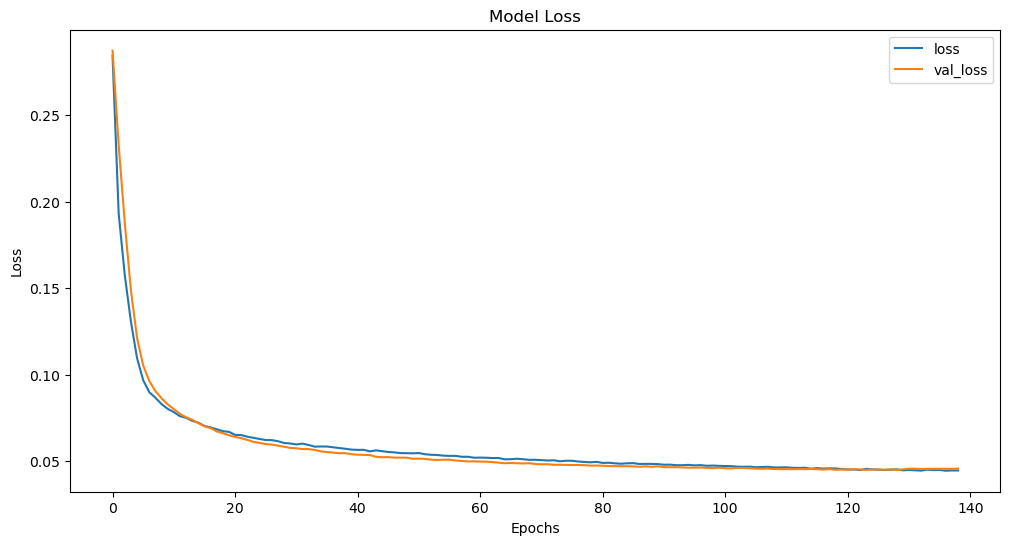

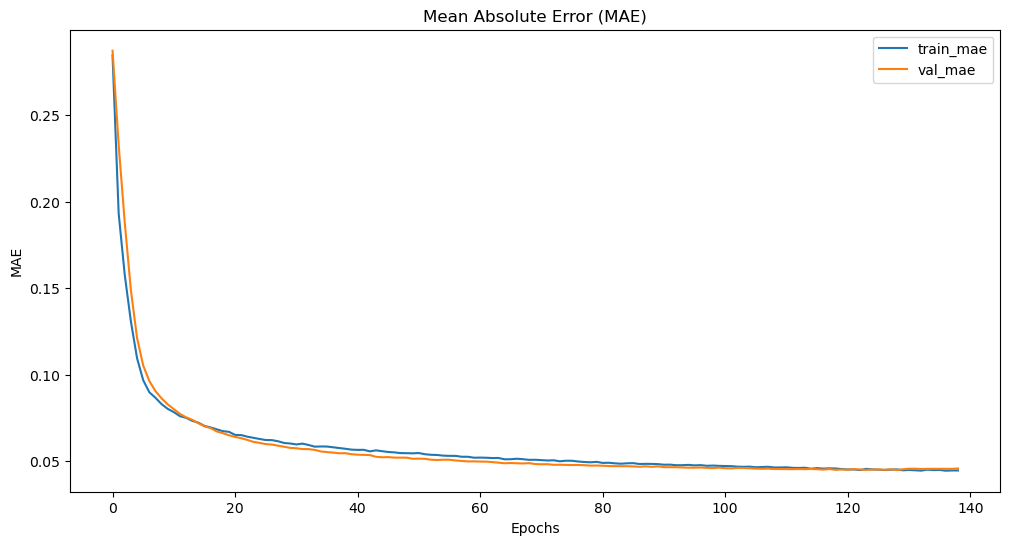

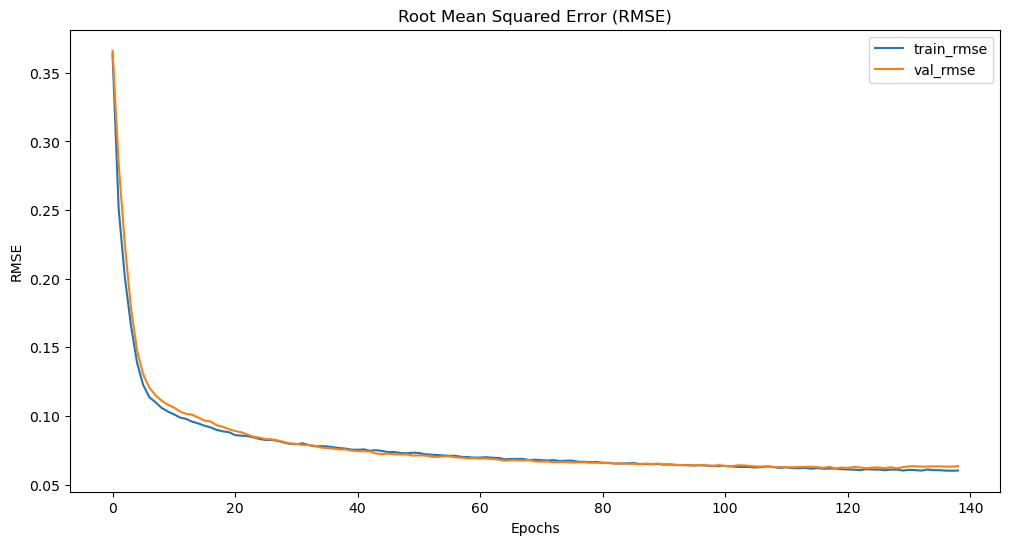

In [71]:
# Plot history for loss, MAE, and RMSE as before
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.show()

train_rmse = np.sqrt(history.history['mse'])
val_rmse = np.sqrt(history.history['val_mse'])
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='train_rmse')
plt.plot(val_rmse, label='val_rmse')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Root Mean Squared Error (RMSE)')
plt.show()

In [75]:
# Calculate MAPE manually, handling zero values
def safe_mape(y_true, y_pred, epsilon=1e-10):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + epsilon))) * 100

train_predictions = model.predict(train_X)
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((train_X_reshaped,train_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_X_reshaped, train_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
train_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
train_mae = mean_absolute_error(inv_y, inv_yhat)
train_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100


test_predictions = model.predict(test_X)
# Reshape test_X for inverse scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# Invert scaling for forecast
inv_yhat = np.concatenate((test_X_reshaped,test_predictions), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]
# Invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X_reshaped, test_y_reshaped), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]
# Calculate RMSE, MAE, MAPE
test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
test_mae = mean_absolute_error(inv_y, inv_yhat)
test_mape = np.mean(np.abs((inv_y - inv_yhat) / inv_y)) * 100

print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"Train MAPE: {train_mape:.3f}%")
print(f"\nTest RMSE: {test_rmse:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"Test MAPE: {test_mape:.3f}%")

609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
Train RMSE: 2.230
Train MAE: 1.632
Train MAPE: 4.552%

Test RMSE: 2.643
Test MAE: 1.919
Test MAPE: 4.833%


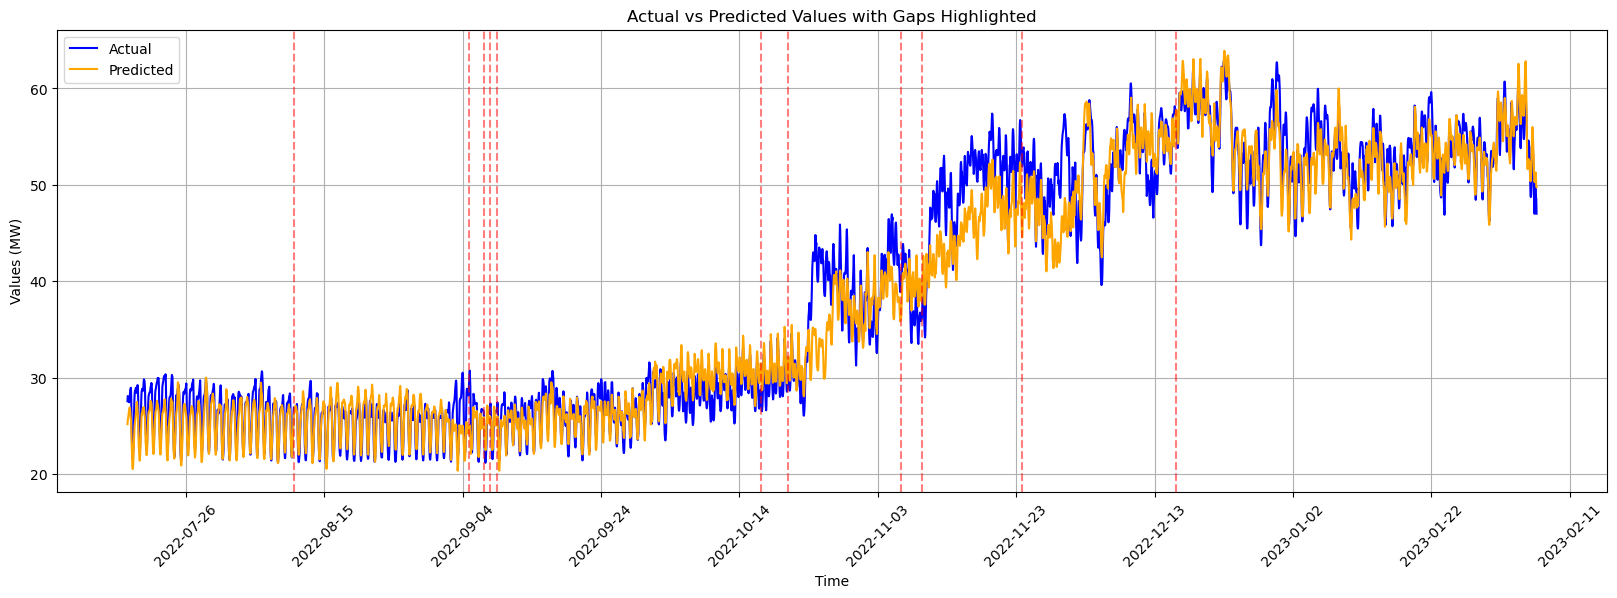

Gaps in data:
Gap Start: 2022-08-10 15:00:00
Gap ends at: 2022-08-10 11:00:00
Time Difference: 2.0 hours

Gap Start: 2022-09-04 21:00:00
Gap ends at: 2022-09-04 18:00:00
Time Difference: 3.0 hours

Gap Start: 2022-09-06 20:00:00
Gap ends at: 2022-09-06 19:00:00
Time Difference: 5.0 hours

Gap Start: 2022-09-07 20:00:00
Gap ends at: 2022-09-07 18:00:00
Time Difference: 4.0 hours

Gap Start: 2022-09-08 20:00:00
Gap ends at: 2022-09-08 16:00:00
Time Difference: 2.0 hours

Gap Start: 2022-10-16 22:00:00
Gap ends at: 2022-10-16 20:00:00
Time Difference: 4.0 hours

Gap Start: 2022-10-20 22:00:00
Gap ends at: 2022-10-20 18:00:00
Time Difference: 2.0 hours

Gap Start: 2022-11-06 06:00:00
Gap ends at: 2022-11-06 02:00:00
Time Difference: 3.0 hours

Gap Start: 2022-11-09 06:00:00
Gap ends at: 2022-11-09 02:00:00
Time Difference: 3.0 hours

Gap Start: 2022-11-23 18:00:00
Gap ends at: 2022-11-23 13:00:00
Time Difference: 2.0 hours

Gap Start: 2022-12-15 22:00:00
Gap ends at: 2022-12-15 18:00:00
Ti

In [76]:
# Extract the test data with timestamps
test_df = LSTM_df.iloc[n_train_hours:, :].copy()
test_df['hour_begins'] = LSTM_df.iloc[n_train_hours:]['hour_begins']

# Identify gaps in the data
actual_vs_predicted = pd.DataFrame({
    'hour_begins': test_timestamps,
    'actual': inv_y,
    'predicted': inv_yhat
})

# Check for gaps in the timestamps (in days)
actual_vs_predicted['hour_begins_diff'] = actual_vs_predicted['hour_begins'].diff().dt.total_seconds() / 3600
gaps = actual_vs_predicted[actual_vs_predicted['hour_begins_diff'] > 1]

# Plot actual vs predicted values with gaps highlighted
plt.figure(figsize=(20, 6))
plt.plot(actual_vs_predicted['hour_begins'], actual_vs_predicted['actual'], label='Actual', color='blue')
plt.plot(actual_vs_predicted['hour_begins'], actual_vs_predicted['predicted'], label='Predicted', color='orange')
for gap_start in gaps['hour_begins']:
    plt.axvline(x=gap_start, color='red', linestyle='--', alpha=0.5)
plt.title('Actual vs Predicted Values with Gaps Highlighted')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)

# Set date format on x-axis every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.show()

# Print the gaps and their nearest significant time differences
print("Gaps in data:")
for index, row in gaps.iterrows():
    previous_timestamp = row['hour_begins'] - pd.Timedelta(hours=row['hour_begins_diff'])

    previous_row = actual_vs_predicted[actual_vs_predicted['hour_begins'] == previous_timestamp]

    gap_start = previous_row['hour_begins'].values[0] if not previous_row.empty else 'N/A'
    gap_end = row['hour_begins']

    print(f"Gap Start: {pd.to_datetime(gap_start).strftime('%Y-%m-%d %H:%M:%S') if gap_start != 'N/A' else 'N/A'}")
    print(f"Gap ends at: {gap_end.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Time Difference: {row['hour_begins_diff']} hours\n")

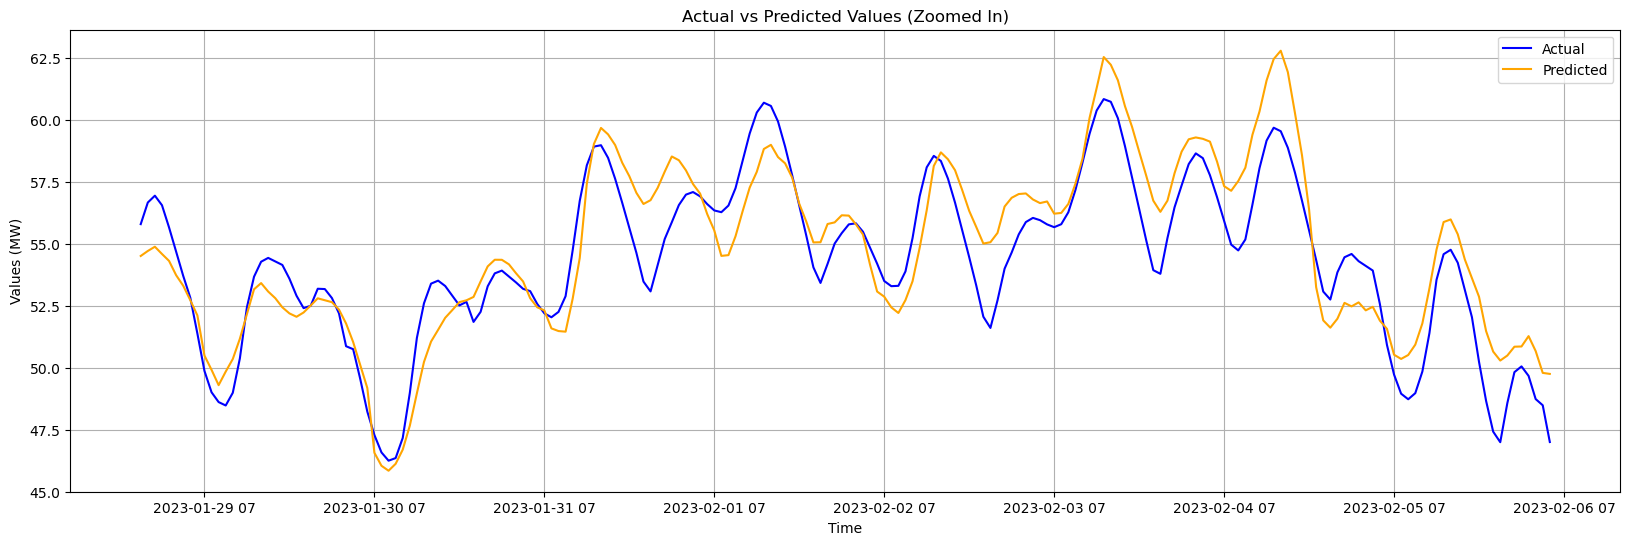

In [77]:
import matplotlib.dates as mdates

# Zoom in to plot
plt.figure(figsize=(20, 6))
plt.plot(test_timestamps[-200:], inv_y[-200:], label='Actual', color='blue')
plt.plot(test_timestamps[-200:], inv_yhat[-200:], label='Predicted', color='orange')
# Format the x-axis to show the full datetime
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
plt.title('Actual vs Predicted Values (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Values (MW)')
plt.legend()
plt.grid(True)
plt.show()